# Some notes on the KZ and LZ experiments, and related experiments

## Where to learn more

[Coherent quantum annealing in a
programmable 2,000 qubit Ising chain,
Nature Physics (2022)](https://doi.org/10.1038/s41567-022-01741-6) Figure 2A reproduced ([preprint](https://doi.org/10.48550/arXiv.2202.05847))

[Quantum critical dynamics in a
5,000-qubit programmable spin glass,
Nature (2023)](https://doi.org/10.1038/s41586-023-05867-2) Figure 2C reproduced ([preprint](https://doi.org/10.48550/arXiv.2207.13800))

[Other publications](https://www.dwavequantum.com/learn/publications/)

[youtube channel](https://www.youtube.com/@dwavequantum)

[Per QPU-properties](https://docs.dwavequantum.com/en/latest/quantum_research/solver_properties_specific.html) (schedules, energy scales, single-qubit freeze out 's') 

[Documentation](https://docs.dwavequantum.com/en/latest/index.html)

[github](https://github.com/dwavesystems/)

[Leap examples](https://cloud.dwavesys.com/leap/examples)

[Leap resources](https://cloud.dwavesys.com/leap/resources)

## Embedding:

Minorminer has a variety of heuristic tools, and tools with guaranteed performance:

* general mappings: [minorminer.find_embeddings](https://docs.dwavequantum.com/en/latest/ocean/api_ref_system/generated/minorminer.find_embedding.html#minorminer-find-embedding)
* 1:1 mappings (native/subgraph): **[minorminer.subgraph.find_subgraph]()**
* Clique and Biclique embedding: [minorminer.busclique.find_clique_embedding](https://docs.dwavequantum.com/en/latest/ocean/api_ref_minorminer/source/clique_embedding.html#minorminer.busclique.find_clique_embedding)

Choose the right tool, it can be very inefficient to make a bad choice. Consider a customized approach for regular cases, e.g.:
* Defect-free (1:1) Next-neighbor-square, Kings, square, triangle); or Defect-free (chains) cubic [hybrid.decomposers.make_origin_embeddings](https://docs.dwavequantum.com/en/latest/ocean/api_ref_hybrid/generated/hybrid.decomposers.make_origin_embeddings.html#hybrid.decomposers.make_origin_embeddings):

Parallelization of embeddings recently supported:
**[minorminer.utils.parallel_embedding.find_multiple_embeddings]()**

In [2]:
# An embedding of a frustrated loop of length 3
from minorminer.subgraph import find_subgraph
from dwave.system import DWaveSampler
h = {i: 0 for i in range(3)}
J = {(0,1): 1, (1,2): 1, (0,2): 1}  # An antiferromagnetic 3-cycle
qpu = DWaveSampler()
emb1to1 = find_subgraph(J.keys(), qpu.to_networkx_graph())  # Edge list 
print(emb1to1)
emb = {k: (v,) for k, v in emb1to1.items()}

{0: 3194, 1: 3209, 2: 2760}


## Noise-mitigation/investigation:
Most of our research papers involve shimming. The general-purpose calibration can be refined for specific models to eliminate specific cross-talks and non-idealities:
* [Calibration refinement](https://doi.org/10.3389/fcomp.2023.1238988) Published paper and (recently updated) demonstration code; We can tune parameters such as flux_biases to restore expected symmetries.
* We can extend this in principle to learning general distributions [pytorch plug-in](https://github.com/dwavesystems/dwave-pytorch-plugin/blob/main/README.rst)

Another option is to use spin-reversal transforms: 
* Spin-reversal transforms with respect to the noise-free evolution amounts to a change of basis (gauge)
* With respect to the programmed realization, a change of basis leads to new noise patterns.
* By averaging we eliminate noise. e.g. the effect of independent and identically distributed flux (h) noise is eliminated at leading order.
```
    qpu = DWaveSampler(solver='Advantage2_system1.1')
    sampler = SpinReversalTransformComposite(qpu)  # Composites applies (and inverts) the transformation
```

Another option is averaging over embeddings:
* Use randomized or parallelized embeddings
```
    qpu = DWaveSampler(solver='Advantage2_system1.1')
    sampler1 = SpinReversalTransformComposite(qpu)  
    source = nx.from_edgelist([(i, i+1) for i in range(3)])  # A path (1d chain) of size 4
    sampler2 = ParallelEmbeddingComposite(sampler2)  # Composites distributes and inverts (a distribution on 4-spins is returned)
```
* Exploit symmetries of the source model (Ising model) to permute a known embedding.
* Many physics models have high symmetry: tranlational, rotational and reflection symmetry. These might be put in by hand, or a tool like pynauty can be used (see e.g. the shimming tutorial).


In [3]:
# Clique, biclique and lattice source model have lots of symmetries, we can permute keys to get new valid embeddings
from dwave.embedding import is_valid_embedding
import networkx as nx
translation_on_3cycle = {0:1, 1:2, 2:0}
emb2 = {translation_on_3cycle[k]: v for k,v in emb.items()}
print('Original valid embedding', emb)
assert is_valid_embedding(emb, J.keys(), qpu.to_networkx_graph())
print('New valid embedding exploiting symmetries of the source', emb2)
assert is_valid_embedding(emb2, J.keys(), qpu.to_networkx_graph())


{0: (3194,), 1: (3209,), 2: (2760,)}
{1: (3194,), 2: (3209,), 0: (2760,)}


In [4]:
# Use of spin-reversal transforms to average programmings related by symmetry can mitigate for flux noise.
# This increases the uniformity across the (6) ground states, in the case of the frustrated loop. Excited states are not typically observed.
from dwave.preprocessing import SpinReversalTransformComposite
from dwave.system.composites import FixedEmbeddingComposite
sampler = FixedEmbeddingComposite(SpinReversalTransformComposite(qpu), embedding=emb)
ss = sampler.sample_ising(h, J, num_reads=1000)
print(ss.record.energy, ss.record.num_occurrences)

[-1. -1. -1. -1. -1. -1.] [169 148 152 172 156 203]


## Schedules and QPU specific properties

Find these on the website, per link:
Assumes the Hamiltonian H = -A(s)/2 \sum_i X_i + B(s)/2 H_p 


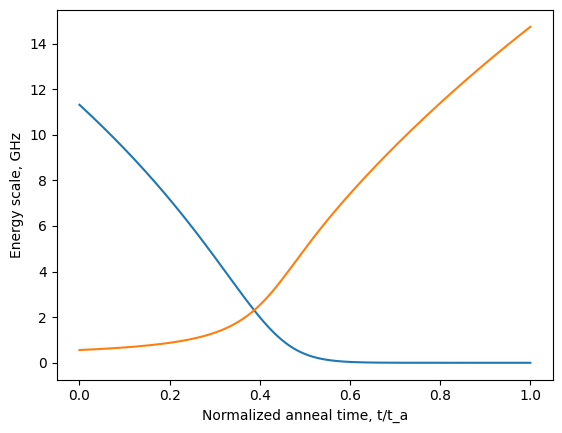

In [32]:
import numpy as np
import matplotlib.pyplot as plt
#from dwave.system import energy_scale_custom_schedule  # When ocean-sdk is updated, I'll demonstrate/debug this code.
sABc = np.loadtxt('09-1312A-A_Advantage2_system1.1_fast_annealing_schedule.csv', delimiter=",", skiprows=1)
plt.plot(sABc[:,0], sABc[:,1])
plt.plot(sABc[:,0], sABc[:,2])
plt.ylabel('Energy scale, GHz')
plt.xlabel('Normalized anneal time, t/t_a')
anneal_schedule = [[0.0, 1.0], [5, 0.45], [99, 0.45], [100, 1.0]]
# tsABc = energy_scales_custom_schedule(sABc, anneal_schedule)
# plt.plot(tsABc[:,1], sABc[:,2])
# plt.plot(tsABc[:,1], sABc[:,3])

## Temperature (quasi-static freezeout)

If the model is maximum entropy subject to some rate of excitations (energy), it is a Boltzmann distribution.

This is expected for single-late freeze-out (thermal equilibrium up to the small A(s) limit, then dynamical arrest)

The local pattern of excitations is sufficient to efficiently infer the temperature with enough samples:
```
    qpu = DWaveSampler(solver='Advantage2_system1.1')
    dwave.system.temperatures.fast_effective_temperature(qpu)  # By default, uses independent spins
```
Note that, if the distribution is not Boltzmann due to ergodicity breaking (trapping by local minima) we expect the rate of local excitations to be smaller than the rate of general excitations. Quantum-Boltzmann and noise effects can also lead to bias in estimators.

In [5]:
# Calculate the maximum-likelihood estimate for T, where P(s) = exp(- 1/T sum_i h_i) and h_i ~ [-1/4, 1/4] independent and identically distributed
from dwave.system.temperatures import fast_effective_temperature
from dwave.system import DWaveSampler
for solver in ['Advantage_system4.1', 'Advantage2_prototype2.6', 'Advantage2_system1.1']:
    qpu = DWaveSampler(solver=solver)
    T, _ = fast_effective_temperature(qpu, h_range=(-1/4, 1/4))  # By default, uses independent spins
    print(f'Unitless temperatures characterizing {solver}', T)

Unitless temperatures characterizing the Advantage_system4.1 0.1729716452609051
Unitless temperatures characterizing the Advantage2_prototype2.6 0.14568234841522454
Unitless temperatures characterizing the Advantage2_system1.1 0.11312321299313849


## Classical dynamics

We include a variety of heuristic optimizer and classical dynamics include path-integral monte carlo, rotor models and simulated annealing

1. Full randomized Gibbs sampling at fixed temperature
2. Continuous-time path integral Monte-Carlo

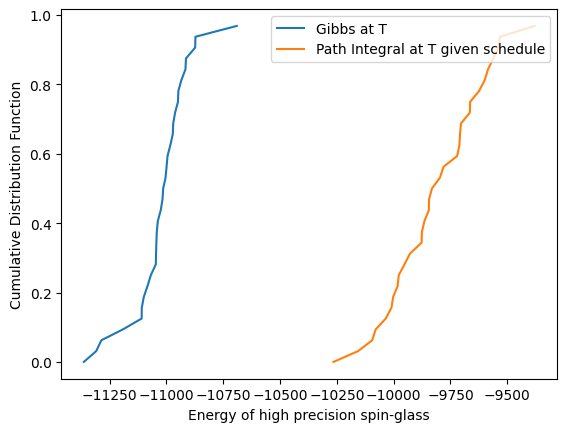

In [34]:
from dwave.samplers import SimulatedAnnealingSampler, PathIntegralAnnealingSampler

h = {i: 0 for i in qpu.nodelist}
J = {e: np.random.random() for e in qpu.edgelist}  # Spin glass

num_reads = 32  # Small sampleset for the demo

# Fixed temperature classical sampler
sampler = SimulatedAnnealingSampler()  # Fixed temperature (this example) classical dynamics
ss = sampler.sample_ising(h, J, beta_schedule=[1/T], num_sweeps_per_beta = 16, num_reads=num_reads, beta_schedule_type='custom', randomize_order=True, acceptance_criteria='Gibbs')
plt.plot(np.sort(ss.record.energy), np.arange(num_reads)/num_reads, label='Gibbs at T')

# Path integral sampling
s_freezeout = 0.684
s_interps = np.arange(16)/15*s_freezeout
Hp_field = np.interp(s_interps, sABc[:,0], sABc[:,2])/T  # Dynamics stop around 0.684, single qubit freezeout
Hd_field = np.interp(s_interps, sABc[:,0], sABc[:,1])/T
sampler = PathIntegralAnnealingSampler()  # Simulated Quantum Annealing
ss = sampler.sample_ising(h, J, Hd_field=Hd_field,Hp_field=Hp_field, num_reads=num_reads, beta_schedule_type='custom')

plt.plot(np.sort(ss.record.energy), np.arange(num_reads)/num_reads, label='Path Integral at T given schedule')
plt.ylabel('Cumulative Distribution Function')
plt.xlabel('Energy of high precision spin-glass')
plt.legend()

# Timing

Timing information is returned as part of the sample set.

We can also estimate the access-time using tools prior to submission

In [35]:
print('Estimated qpu access time', qpu.solver.estimate_qpu_access_time(num_qubits=len(h), num_reads=num_reads))
num_reads = 1000
ss = qpu.sample_ising(h, J, num_reads=num_reads, answer_mode='raw')
print(ss.info['timing'])

{'qpu_sampling_time': 178420.0, 'qpu_anneal_time_per_sample': 20.0, 'qpu_readout_time_per_sample': 97.85, 'qpu_access_time': 213044.4, 'qpu_access_overhead_time': 2934.6, 'qpu_programming_time': 34624.4, 'qpu_delay_time_per_sample': 60.57, 'total_post_processing_time': 25.0, 'post_processing_overhead_time': 25.0}
Estimated qpu access time 213054.80999999997
